In [ ]:
import pandas as pd
import random
import numpy as np
from random import randint
import torch
from transformers import AutoTokenizer, AutoModel
import gc

import matplotlib.pyplot as plt
import matplotlib

import time
import memory_profiler

%load_ext memory_profiler

from pathlib import Path

In [ ]:
torch.__version__

'1.8.1+cu111'

In [ ]:
%load_ext autoreload
%autoreload 2

from text_embeddings_src.model_stuff import train_loop_logistic
from text_embeddings_src.data_stuff import (
    MultOverlappingSentencesPairDataset,
)

In [ ]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [ ]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
data_path = Path("../data")

In [ ]:
plt.style.use("matplotlib_style.txt")

In [ ]:
model = None
gc.collect()
torch.cuda.empty_cache()

# Import

## Data

In [ ]:
%%time
compression_opts = dict(method="zip", archive_name="iclr.pickle.csv")

iclr = pd.read_pickle(
    data_path / "iclr.pickle.zip",
    # index_col=False,
    compression=compression_opts,
)

CPU times: user 198 ms, sys: 16.2 ms, total: 214 ms
Wall time: 347 ms


In [ ]:
iclr

,year,id,title,abstract,authors,decision,scores,keywords,gender-first,gender-last,t-SNE x,t-SNE y
0,2018,ryBnUWb0b,Predicting Floor-Level for 911 Calls with Neur...,"In cities with tall buildings, emergency respo...","William Falcon, Henning Schulzrinne",Accept (Poster),"[7, 6, 6]","[recurrent neural networks, rnn, lstm, mobile ...",male,None,2.536470,0.739367
1,2018,Skk3Jm96W,Some Considerations on Learning to Explore via...,We consider the problem of exploration in meta...,"Bradly Stadie, Ge Yang, Rein Houthooft, Xi Che...",Invite to Workshop Track,"[7, 4, 6]","[reinforcement learning, rl, exploration, meta...",male,male,49.831927,-29.813831
2,2018,r1RQdCg0W,MACH: Embarrassingly parallel $K$-class classi...,We present Merged-Averaged Classifiers via Has...,"Qixuan Huang, Anshumali Shrivastava, Yiqiu Wang",Reject,"[6, 6, 6]","[extreme classification, large-scale learning,...",None,None,-22.502752,9.577367
3,2018,rJ3fy0k0Z,Deterministic Policy Imitation Gradient Algorithm,The goal of imitation learning (IL) is to enab...,"Fumihiro Sasaki, Atsuo Kawaguchi",Reject,"[6, 5, 5]",[imitation learning],None,None,40.437523,-47.690889
4,2018,SkBYYyZRZ,Searching for Activation Functions,The choice of activation functions in deep net...,"Prajit Ramachandran, Barret Zoph, Quoc V. Le",Invite to Workshop Track,"[5, 4, 7]","[meta learning, activation functions]",None,None,-33.260086,-4.038115
...,...,...,...,...,...,...,...,...,...,...,...,...
16531,2023,w4eQcMZsJa,Text-Driven Generative Domain Adaptation with ...,Combined with the generative prior of pre-trai...,"Zhenhuan Liu, Liang Li, Jiayu Xiao, Zhengjun Z...",Desk rejected,[],"[gan, stylegan, clip, domain adaptation, style...",None,None,59.296526,5.206691
16532,2023,SDHSQuBpf2,"Laziness, Barren Plateau, and Noises in Machin...",We define \emph{laziness} to describe a large ...,"Zexi Lin, Liang Jiang",Desk rejected,[],"[theoretical issues in deep learning, learning...",None,male,-29.178083,-21.810583
16533,2023,HyIY8u5LVDr,Discovering the Representation Bottleneck of G...,Most graph neural networks (GNNs) rely on the ...,"Fang Wu, Siyuan Li, Lirong Wu, Dragomir Radev,...",Desk rejected,[],"[gnn bottleneck, graph rewiring, representatio...",None,male,-7.573978,68.386671
16534,2023,470wZ5Qk4ur,Results for Perfect Classification for Graph A...,We study the ability of one layer Graph Attent...,"Kimon Fountoulakis, Amit Levi",Desk rejected,[],[],None,male,-7.753593,60.764583


In [ ]:
titles_abstracts_together = [
    iclr.title[i] + " " + iclr.abstract[i] for i in range(len(iclr))
]

In [ ]:
print(len(titles_abstracts_together))

16536


## Labels

In [ ]:
# iclr = pd.read_pickle("iclr.pickle.zip")

keywords = [
    "network",
    "graph",
    "reinforcement",
    "language",
    "adversarial",
    "federated",
    "contrastive",
    "domain",
    "diffusion",
    "out-of-dis",
    "continual",
    "distillation",
    "architecture",
    "privacy",
    "protein",
    "fair",
    "attention",
    "video",
    "meta-learning",
    "generative adv",
    "autoencoder",
    "game",
    "semi-sup",
    "pruning",
    "physics",
    "3d",
    "translation",
    "optimization",
    "recurrent",
    "word",
    "bayesian",
]
keywords = np.array(keywords)

y = np.zeros(iclr.shape[0]) * np.nan

for num, keyword in enumerate(keywords):
    mask = [keyword.lower() in t.lower() for t in iclr.title]
    y[mask & ~np.isnan(y)] = -1
    y[mask & np.isnan(y)] = num

print(y.size)
print(np.sum(~np.isnan(y)))
print(np.sum(y >= 0))

labeled = y >= 0

iclr_labeled = iclr[labeled].reset_index(drop=True)
y_labeled = y[labeled].astype(int)
iclr_labeled["y"] = y_labeled
iclr_labeled["label"] = keywords[y_labeled]

16536
8964
6849


# Training

## Training run23
UPDATE TEXT

Optimize the [av] representation for 10 epochs for BERT, MPNET, and SBERT. batch_size=64, lr=2e-5.

Now using the multi sentence data augmentation (MultOverlappingSentencesPairDataset), with n_cons_sntcs=2

Now I do two forms of evaluation isntead of knn accuracy:
- do t-SNE using the representations of ater 1 epoch and after 10 epochs
- kNN recall in which the "original high-dim" representation is the space trained after 10 epochs and the "low-dim" one is after one epoch

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    # "allenai/scibert_scivocab_uncased",
    # "allenai/specter",
    # "malteos/scincl",
]

In [ ]:
%%time
for i, model_name in enumerate(model_names):
    ## fix random seeds
    seed = 42
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)
    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed
    random.seed(seed)

    # set up model
    print("Model: ", model_name)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    print(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
    )
    gen = torch.Generator()
    gen.manual_seed(seed)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    losses, accuracies = train_loop_logistic(
        model,
        training_loader,
        device,
        iclr.abstract.to_list(),
        tokenizer,
        labeled,
        iclr_labeled["y"].to_numpy(),
        optimized_rep="av",
        n_epochs=3,
        lr=2e-5,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower())
    (variables_path / saving_path).mkdir(exist_ok=True)

    np.save(variables_path / saving_path / "losses_run23", losses)
    np.save(
        variables_path / saving_path / "logistic_accuracy_run23", accuracies
    )

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  BERT
Running on device: cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-uncased


  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetModel: ['lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing MPNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predi

microsoft/mpnet-base


  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

### Plot

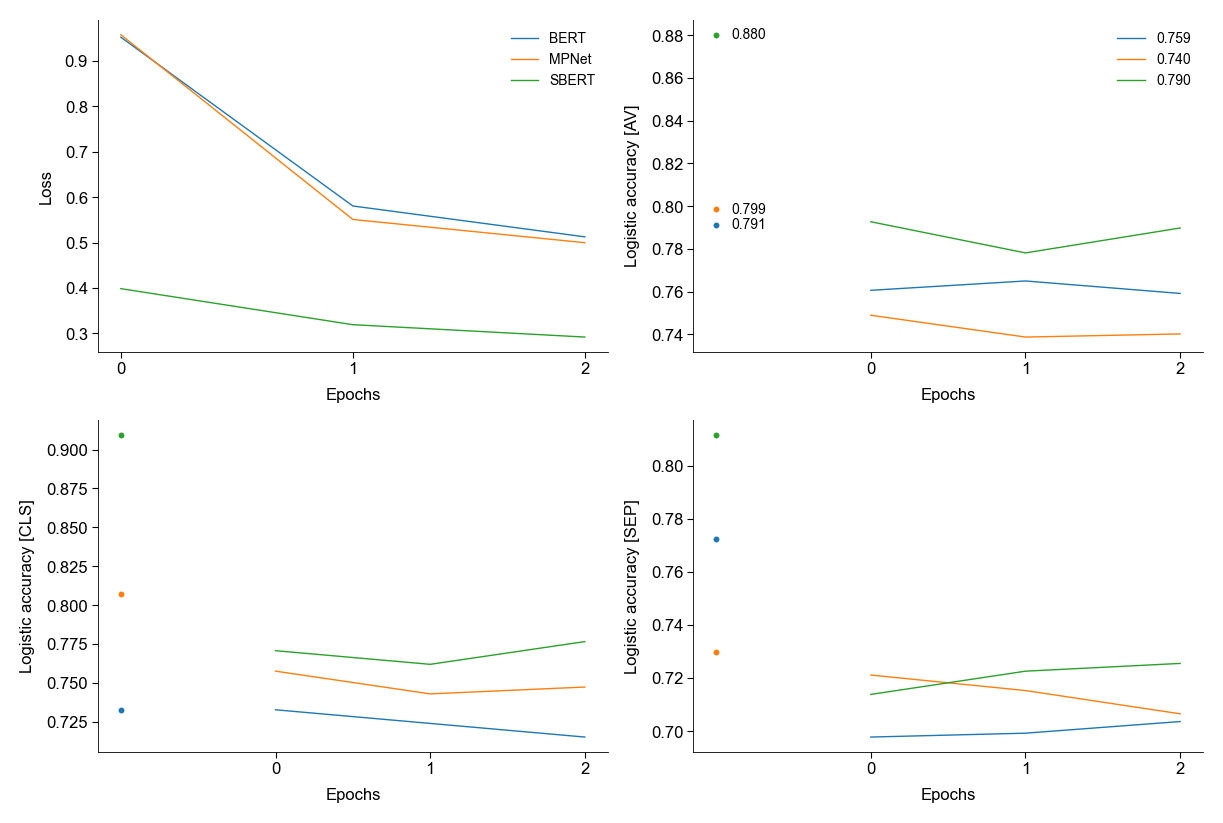

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(2, 2, figsize=(6, 4), dpi=200)
n_epochs = 3
colormap = plt.get_cmap("tab10")

for i, model_name in enumerate(model_names):
    ## load things
    saving_path = Path("embeddings_" + model_name.lower())
    losses = np.load(variables_path / saving_path / "losses_run23.npy")
    accuracies = np.load(
        variables_path / saving_path / "logistic_accuracy_run23.npy"
    )
    accuracy_baseline = np.load(
        variables_path / saving_path / "logistic_accuracy.npy"
    )

    ## plot
    color = colormap(i)

    # losses
    axs[0, 0].plot(
        np.arange(n_epochs),
        np.mean(losses, axis=1),
        label=model_name,
        color=color,
    )
    axs[0, 0].set_xticks(np.arange(n_epochs))
    axs[0, 0].set_xlabel("Epochs")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].legend()

    # AV
    axs[0, 1].plot(
        np.arange(n_epochs),
        accuracies[:, 0],
        label=f"{accuracies[-1, 0]:.3f}",
        color=color,
    )
    axs[0, 1].scatter(-1, accuracy_baseline[0], c=color, s=5)
    axs[0, 1].text(
        -0.9,
        accuracy_baseline[0],
        f"{accuracy_baseline[0]:.3f}",
        fontsize=5,
        va="center",
        ha="left",
    )
    axs[0, 1].legend()
    axs[0, 1].set_xticks(np.arange(n_epochs))
    # axs[0, 1].set_ylim(0.35, 1)
    axs[0, 1].set_xlabel("Epochs")
    axs[0, 1].set_ylabel("Logistic accuracy [AV]")

    # CLS
    axs[1, 0].plot(
        np.arange(n_epochs),
        accuracies[:, 1],
        label=model_name,
        color=color,
    )
    axs[1, 0].scatter(-1, accuracy_baseline[1], c=color, s=5)
    axs[1, 0].set_xticks(np.arange(n_epochs))
    # axs[1, 0].set_ylim(0.35, 1)
    axs[1, 0].set_xlabel("Epochs")
    axs[1, 0].set_ylabel("Logistic accuracy [CLS]")

    # SEP
    axs[1, 1].plot(
        np.arange(n_epochs),
        accuracies[:, 2],
        label=model_name,
        color=color,
    )
    axs[1, 1].scatter(-1, accuracy_baseline[2], c=color, s=5)
    axs[1, 1].set_xticks(np.arange(n_epochs))
    # axs[1, 1].set_ylim(0.35, 1)
    axs[1, 1].set_xlabel("Epochs")
    axs[1, 1].set_ylabel("Logistic accuracy [SEP]")

fig.savefig(figures_path / "loss_and_logistic_accuracy_training_run23_v2.png")